## Amplitude Thresholding Tutorial 

The code used in this script is modified from https://github.com/tbardouille/camcan_betaEvents_ageing and https://github.com/tbardouille/papto_camcan

This method takes in a 1-dimensional time series of preprocessed electrophysiological data. A dataframe containing the characteristics (timing, frequency, power, etc.) of each detected burst is returned. 

Note that this tutorial relies on the utility script spectralevents_functions.py available at https://github.com/lindseypower/BurstDetection_Tutorials

In [1]:
# Imports
import scipy.io as io
import numpy as np 
import pandas as pd
from spectralevents_functions import * 
import multiprocessing as mp
import os
import math
import seaborn as sbn
import mne

In [2]:
# Read in one-dimensional time series (preprocessed)
data_dir =  '/export03/data/lindseyp/burst_methods_review/' 
data = np.loadtxt(data_dir + '1d_array.txt')
print(data.shape)

(566000,)


### 1. Select a Threshold

**This step is used to define an optimal threshold based on your data, however, this is optional. You may also choose to simply select a fixed threshold based on previous literature. If you would like to set a fixed threshold, proceed to step 2 and set 'thrFOM' to the value of your choosing.**

Calls find_bestThreshold method from spectralevents_functions.py 

Calculates a TFR and applies each listed threshold to select high power pixels in the TFR. Calculates correlation between number of high-power pixels and the average power of the signal. The best threshold is identified as that with the greatest correlation. 

Method adapted from Shin et al, 2017 (https://doi.org/10.7554/eLife.29086) and Brady et al, 2022 (https://doi.org/10.1016/j.neuroimage.2022.118974)

In [3]:
# TFR params #
Fs = 1000.0      # Sampling frequency (Hz)
fmin = 15.0         # Hertz (integer)
fmax = 30.0        # Hertz (integer)
fstep = 1.0         # Hertz (integer)
width = 10        # width of the morlet wavelet
fVec = np.arange(fmin, fmax+1, fstep)

# Test different thresholds to select the best one for identifying high power events 
thresholds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
df_plot = find_bestThreshold(data, thresholds, Fs, width, fVec)

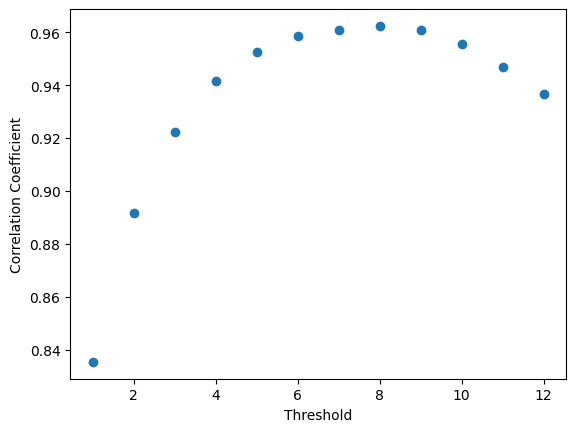

In [4]:
# Plot the correlation between percent thresholded pixels and average power for each threshold 
mean_coef_list = []
new_thresholds = []
for threshold in thresholds:
    sub_df = df_plot[df_plot['threshold']==threshold]
    mean_coef = np.mean(sub_df['coef'])
    if not math.isnan(mean_coef):
        mean_coef_list.append(mean_coef)
        new_thresholds.append(threshold)
plt.scatter(new_thresholds, mean_coef_list)
plt.xlabel('Threshold')
plt.ylabel('Correlation Coefficient')
plt.show()

In [5]:
# Overall best threshold: maximum correlation coefficient
max_coef = np.max(np.asarray(mean_coef_list))
max_threshold = new_thresholds[np.where(mean_coef_list==max_coef)[0][0]]
print('Best Threshold:')
print(max_threshold)

Best Threshold:
8


### 2. Compute a Time-Frequency Representation (TFR)

Calls spectralevents_ts2tfr from spectralevents_functions.py 

Calculates the TFR (in spectral power) of a time-series waveform by convolving in the time-domain with a Morlet wavelet. 

Method adapted from Shin et al, 2017 (https://doi.org/10.7554/eLife.29086) and Brady et al., 2020 (https://doi.org/10.1016/j.neuroimage.2020.117245)

In [6]:
# Set up some parameters for burst detection #
findMethod = 1  
thrFOM = max_threshold # Here you may wish to overwrite this with a specified threshold of your choosing
footprintFreq = 4
footprintTime = 80
threshold = 0.00
neighbourhood_size = (footprintFreq,footprintTime)

# Make a TFR for data
chan_data = np.reshape(data, (data.shape[0],1)) #reshapes because function expects epochs 
TFR, tVec, fVec = spectralevents_ts2tfr(chan_data,fVec,Fs,width)

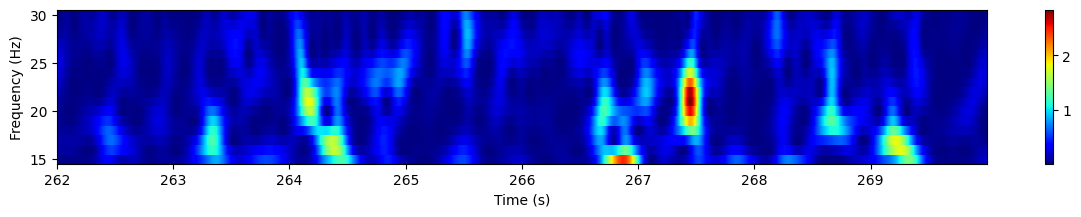

In [7]:
# Plot sample of TFR
TFR_crop = TFR[:,:,262000:270000]
fig = plt.figure(figsize=(15,2))
im = plt.pcolor(tVec[262000:270000], fVec, np.squeeze(TFR_crop), cmap='jet')
fig.colorbar(im)
plt.xlabel('Time (s)')
plt.ylabel ('Frequency (Hz)')
plt.show()

### 3. Identify High-Power Spectral Events 

Calls spectralevents_find from spectralevents_functions.py 

Finds spectral events by first retrieving all local maxima in un-normalized TFR using python equivalent of imregionalmax (MATLAB), then selects suprathreshold peaks within the frequency band of interest (threshold defined based on specified multiple of median power in each frequency bin)

Method adapted from Shin et al, 2017 (https://doi.org/10.7554/eLife.29086) and Brady et al, 2020 (https://doi.org/10.1016/j.neuroimage.2020.117245)

In [8]:
# Set all class labels to the same value 
numTrials = TFR.shape[0]
classLabels = [1 for x in range(numTrials)]
        
# Find spectral events based on TFR
spectralEvents = spectralevents_find (findMethod, thrFOM, tVec,
    fVec, TFR, classLabels, neighbourhood_size, threshold, Fs)

# Create a dataframe of burst characteristics    
df = pd.DataFrame(spectralEvents)
burst_df = df[df['Outlier Event']==True]

burst_df.head(5)

,Trial,Hit/Miss,Peak Frequency,Lower Frequency Bound,Upper Frequency Bound,Frequency Span,Peak Time,Event Onset Time,Event Offset Time,Event Duration,Peak Power,Normalized Peak Power,Outlier Event
6,0,1,15.0,15.0,16.0,4,4.015,3.841,4.173,0.332,5.075105,69.161617,True
7,0,1,15.0,15.0,30.0,32,4.895,4.713,4.969,0.256,0.882531,12.026803,True
90,0,1,15.0,15.0,18.0,8,62.301,62.197,62.412,0.215,0.821030,11.188685,True
91,0,1,15.0,15.0,17.0,6,62.822,62.732,62.913,0.181,0.662843,9.032974,True
129,0,1,15.0,15.0,17.0,6,92.422,92.316,92.527,0.211,0.681017,9.280639,True


In [9]:
# Record burst rate 
burstRate = burst_df.shape[0]/(chan_data.shape[0]/Fs)
print("Burst Rate:")
print(burstRate)

Burst Rate:
1.1590106007067138


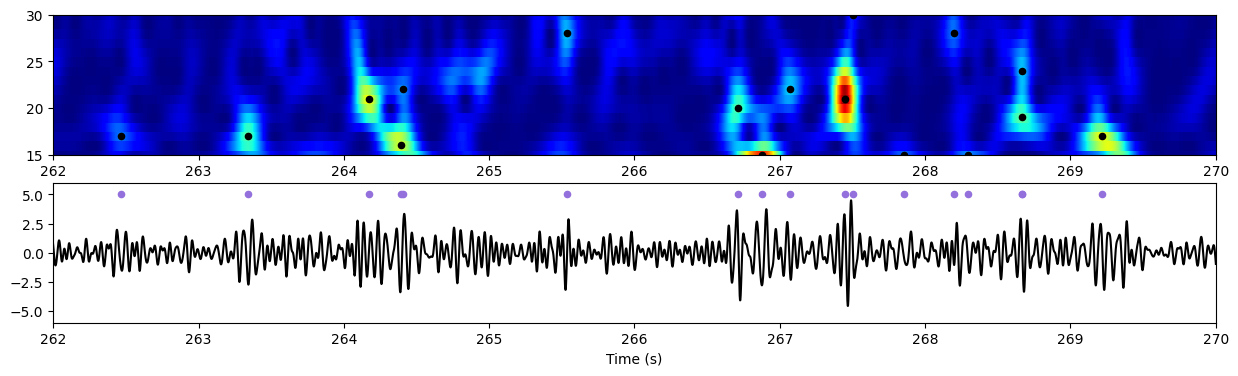

In [11]:
# Plot showing where the bursts are identified in the TFR along with a visualization of the corresponding times in the raw signal 
fig, axs = plt.subplots(2,1, figsize=(15,4))
scale_val = 20

# Plot TFR with overlaid burst times/frequencies 
TFR_crop = TFR[:,:,262000:270000]
im = axs[0].pcolor(tVec[262000:270000], fVec, np.squeeze(TFR_crop), cmap='jet')
axs[0].scatter(burst_df['Peak Time'], burst_df['Peak Frequency'] ,c='black',s=scale_val,zorder=1)
axs[0].set_xlim(262,270)
axs[0].set_ylim(15,30)

# Plot indication of burst peak times with respect to raw (bandpassed) time series
beta_filt_dat = mne.filter.filter_data(np.squeeze(chan_data), Fs, l_freq=15.0, h_freq=30.0,verbose=False)
times = np.arange(0,chan_data.shape[0])/Fs
axs[1].plot(times,beta_filt_dat,zorder=0,c='black')
axs[1].scatter(burst_df['Peak Time'], [5]*len(burst_df['Peak Time']) ,c='mediumpurple',s=scale_val,zorder=1)
axs[1].set_ylim(-6,6)
axs[1].set_xlim(262,270)
plt.xlabel('Time (s)')

plt.show()